# NLP Sentiment Analyzer

In [1]:

%matplotlib inline

import sqlite3
import pandas as pd
import numpy as np
import nltk
import re
import string
import matplotlib.pyplot as plt
import numpy as np
import scipy.sparse as sparse
import matplotlib.pyplot as plt
import itertools

from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import HashingVectorizer
from sklearn.cross_validation import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn import metrics
from nltk.corpus import stopwords
from matplotlib.gridspec import GridSpec
from sklearn.cross_validation import StratifiedKFold
from sklearn.naive_bayes import BernoulliNB
from sklearn import linear_model
from sklearn.tree import DecisionTreeClassifier
from sklearn.decomposition import TruncatedSVD
from sklearn.metrics import recall_score

C:\Users\ayush\Anaconda3\lib\site-packages\sklearn\cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


## Data

Amazon fine food reviews - 
This dataset consists of reviews of fine foods from amazon. The data span a period of more than 10 years, including all ~500,000 reviews up to October 2012. Reviews include product and user information, ratings, and a plain text review. It also includes reviews from all other Amazon categories.

Data includes:
- Reviews from Oct 1999 - Oct 2012
- 568,454 reviews
- 256,059 users
- 74,258 products
- 260 users with > 50 reviews

https://www.kaggle.com/snap/amazon-fine-food-reviews

## Reading the Data

In [2]:
sqlobject = sqlite3.connect('./database.sqlite')

In [3]:
reviews = pd.read_sql_query("""SELECT Score, Summary, Time, ProductId FROM Reviews""", sqlobject)

In [4]:
original = reviews.copy()

In [5]:
reviews = original.copy()

In [6]:
print(reviews.shape)

(568454, 4)


In [7]:
reviews = reviews.dropna()

In [8]:
print (reviews.shape)

(568454, 4)


No null values in the dataset

## Data Exploration

In [9]:
reviews

,Score,Summary,Time,ProductId
0,5,Good Quality Dog Food,1303862400,B001E4KFG0
1,1,Not as Advertised,1346976000,B00813GRG4
2,4,"""Delight"" says it all",1219017600,B000LQOCH0
3,2,Cough Medicine,1307923200,B000UA0QIQ
4,5,Great taffy,1350777600,B006K2ZZ7K
5,4,Nice Taffy,1342051200,B006K2ZZ7K
6,5,Great! Just as good as the expensive brands!,1340150400,B006K2ZZ7K
7,5,"Wonderful, tasty taffy",1336003200,B006K2ZZ7K
8,5,Yay Barley,1322006400,B000E7L2R4
9,5,Healthy Dog Food,1351209600,B00171APVA


In [10]:
scores = reviews['Score']
reviews['Score'] = reviews['Score'].apply(lambda x : 'pos' if x > 3 else 'neg')

We are classifying the reviews on the basis of the ratings and generating labels as 'pos' and 'neg'. If score > 3 then it is a positive review otherwise negative.

In [11]:
scores.mean()

4.183198640523243

In [12]:
reviews.groupby('Score')['Summary'].count()

Score
neg    124677
pos    443777
Name: Summary, dtype: int64

In [208]:
print ('Percentage of negative reviews %.2f %%' % ((reviews.groupby('Score')['Summary'].count()['neg'])*100.0/len(reviews)))
print ('Percentage of positive reviews %.2f %%' % ((reviews.groupby('Score')['Summary'].count()['pos'])*100.0/len(reviews)))

Percentage of negative reviews 21.93 %
Percentage of positive reviews 78.07 %


## Data Visualization

([<matplotlib.patches.Wedge at 0x1ec5d593320>,
 [Text(4.63116,3.81475,'negative'), Text(-4.24523,-3.49686,'positive')],
 [Text(2.70151,2.22527,'21.9%'), Text(-2.31558,-1.90738,'78.1%')])

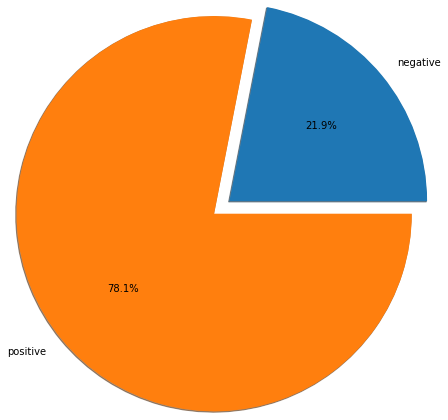

In [209]:
the_grid = GridSpec(2, 2)
labels='negative','positive'
plt.subplot(the_grid[0, 0], aspect=1)

plt.pie(reviews.groupby('Score')['Summary'].count().values, labels=labels, autopct='%1.1f%%', shadow=True, radius=5,explode = (0.5,0))

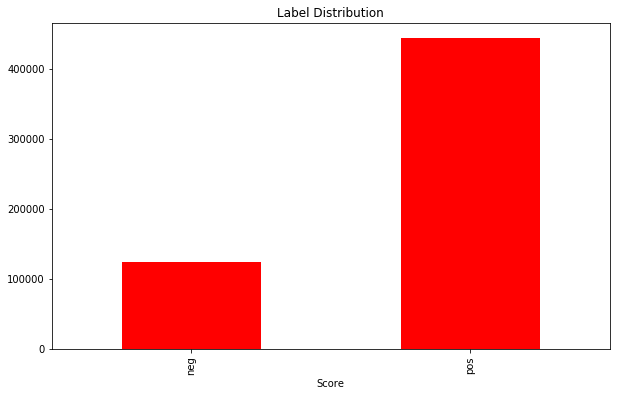

In [210]:
reviews.groupby('Score')['Summary'].count().plot(kind='bar',color=['r','g'],title='Label Distribution',figsize=(10,6))

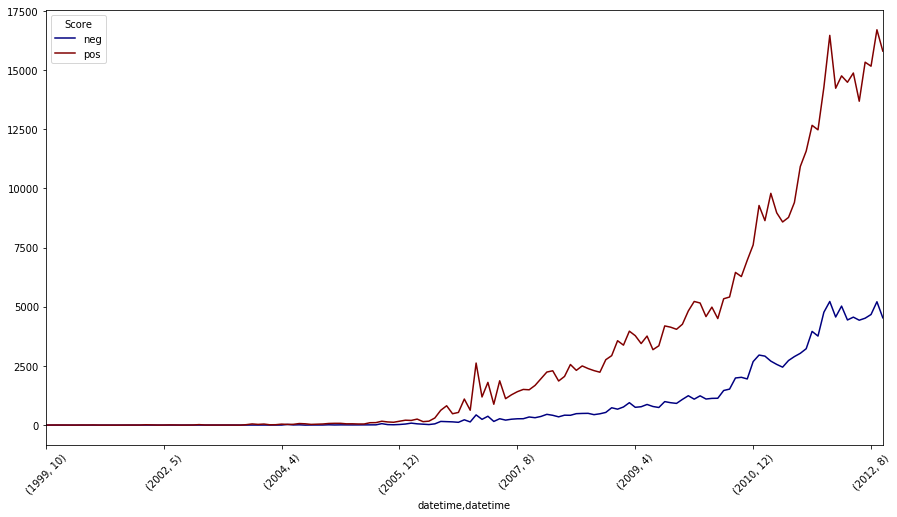

In [211]:
reviews['datetime'] = pd.to_datetime(reviews["Time"], unit='s')
reviews_grp = reviews.groupby([reviews.datetime.dt.year, reviews.datetime.dt.month, reviews.Score]).count()['ProductId'].unstack().fillna(0)


reviews_grp.plot(figsize=(15,8), rot=45, colormap='jet')

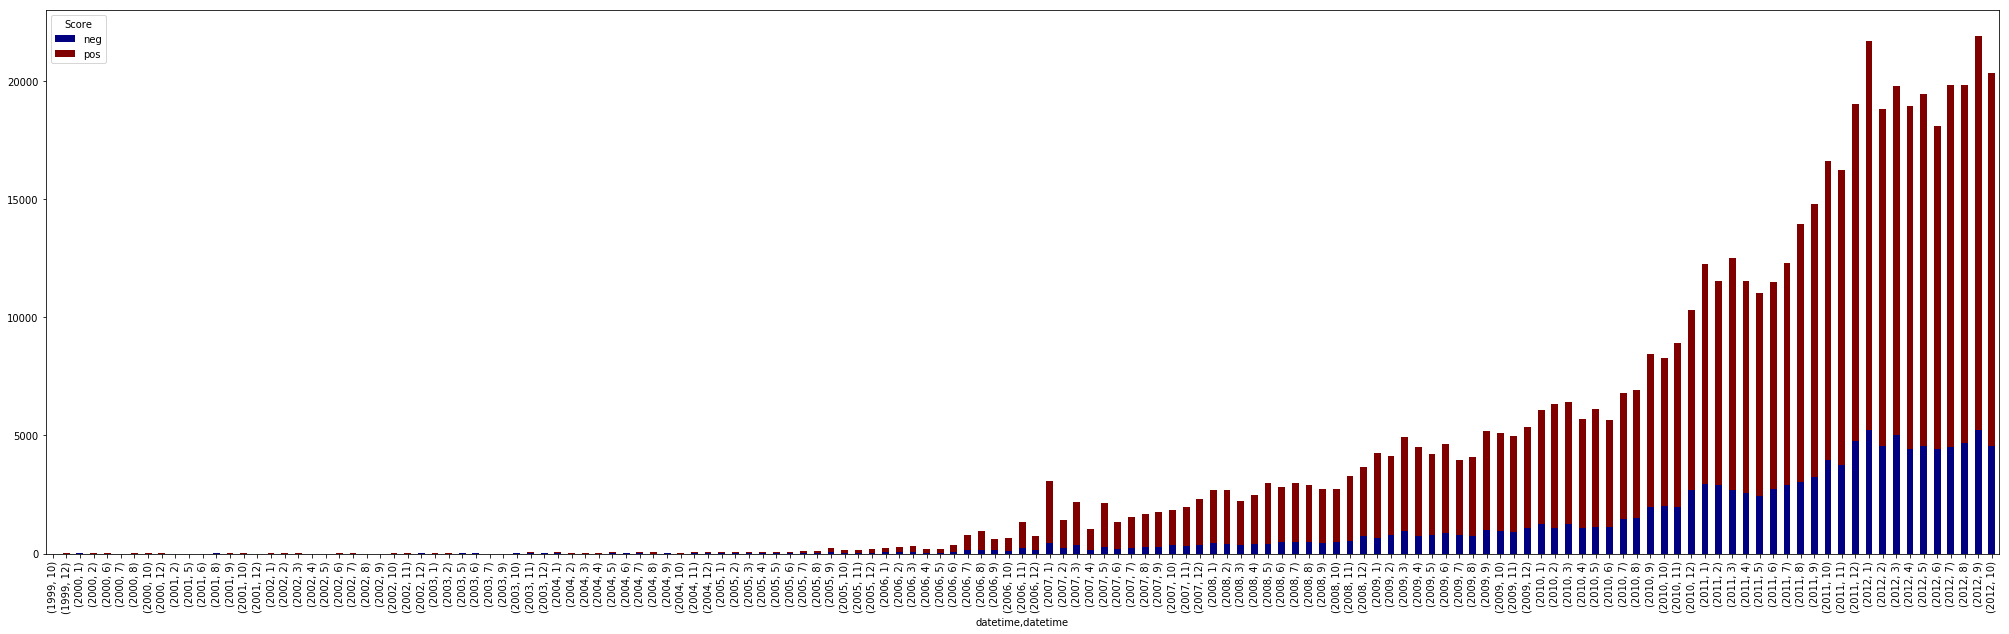

In [212]:
reviews['datetime'] = pd.to_datetime(reviews["Time"], unit='s')
reviews_grp = reviews.groupby([reviews.datetime.dt.year, reviews.datetime.dt.month, reviews.Score]).count()['ProductId'].unstack().fillna(0)


reviews_grp.plot(kind="bar",figsize=(35,10), stacked=True, colormap='jet')

We are visualizing the reviews on the basis of time period. Before the year 2006, less amount of reviews were given by people. But later the reviews started increasing depending on the scale of amazon.

# Data Preprocessing

In [101]:
def plot_confusion_matrix(cm, title='Confusion matrix', cmap=plt.cm.Blues):
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(set(labels)))
    plt.xticks(tick_marks, ['neg','pos'], rotation=45)
    plt.yticks(tick_marks, ['neg','pos'])
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    

In [102]:
def splitPosNeg(Summaries):
    neg = reviews.loc[Summaries['Score']=='neg']
    pos = reviews.loc[Summaries['Score']=='pos']
    return [pos,neg]

In [103]:
[pos,neg] = splitPosNeg(reviews)

### Preprocessing using NLTK

In [107]:
lemmatizer = nltk.WordNetLemmatizer()

translation = str.maketrans(string.punctuation,' '*len(string.punctuation))

def preprocessingusingnltk(line):
    tokens=[]
    line = line.translate(translation)
    line = nltk.word_tokenize(line.lower())
    for t in line:
        stemmed = lemmatizer.lemmatize(t)
        tokens.append(stemmed)
    return ' '.join(tokens)

In [108]:
pos_data = []
neg_data = []
for p in pos['Summary']:
    pos_data.append(preprocessingusingnltk(p))

for n in neg['Summary']:
    neg_data.append(preprocessingusingnltk(n))

In [109]:
data = pos_data + neg_data
labels = np.concatenate((pos['Score'].values,neg['Score'].values))

In [110]:
[Data_train,Data_test,Train_labels,Test_labels] = train_test_split(data,labels , test_size=0.25, random_state=20160121,stratify=labels)

In [111]:
t = []
for line in Data_train:
    l = nltk.word_tokenize(line)
    for w in l:
        t.append(w)

 Word Features Length:  27048


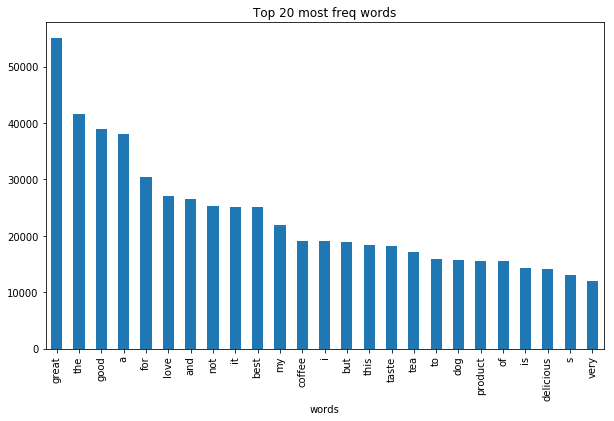

In [112]:
word_features = nltk.FreqDist(t)
print (" Word Features Length: ", len(word_features))
word_his = pd.DataFrame(word_features.most_common(25),columns=['words','count'])
word_his.plot(kind='bar',x=word_his['words'],legend=False,title='Top 20 most freq words',figsize=(10,6))

We can not classify using these features because they contain words which are have no meaning in determining the sentiments and should be removed. Thus we do preprocessing using our custom tokenizer to get better word features. 

### Preprocessing using our own tokenizer

In [201]:
appos = {
"aren't" : "are not",
"can't" : "cannot",
"couldn't" : "could not",
"didn't" : "did not",
"doesn't" : "does not",
"don't" : "do not",
"hadn't" : "had not",
"hasn't" : "has not",
"k":     "okay",
"haven't" : "have not",
"he'd" : "he would",
"he'll" : "he will",
"ive" :"i have",
"he's" : "he is",
"i'd" : "I would",
"i'd" : "I had",
"i'll" : "I will",
"i'm" : "I am",
"isn't" : "is not",
"it's" : "it is",
"it'll":"it will",
"i've" : "I have",
"let's" : "let us",
"mightn't" : "might not",
"mustn't" : "must not",
"shan't" : "shall not",
"she'd" : "she would",
"she'll" : "she will",
"she's" : "she is",
"shouldn't" : "should not",
"that's" : "that is",
"there's" : "there is",
"they'd" : "they would",
"they'll" : "they will",
"they're" : "they are",
"they've" : "they have",
"we'd" : "we would",
"we're" : "we are",
"weren't" : "were not",
"we've" : "we have",
"what'll" : "what will",
"what're" : "what are",
"what's" : "what is",
"what've" : "what have",
"where's" : "where is",
"who'd" : "who would",
"who'll" : "who will",
"who're" : "who are",
"who's" : "who is",
"who've" : "who have",
"won't" : "will not",
"wouldn't" : "would not",
"you'd" : "you would",
"you'll" : "you will",
"you're" : "you are",
"you've" : "you have",
"'re": " are",
"wasn't": "was not",
"we'll":" will",
"didn't": "did not"
}

In [202]:
stopwords =[ 'i',
'me',
'my',
'myself',
'we',
'our',
'ours',
'ourselves',
'you',
'your',
'yours',
'yourself',
'yourselves',
'he',
'him',
'his',
'himself',
'she',
'her',
'hers',
'herself',
'it',
'its',
'itself',
'they',
'them',
'their',
'theirs',
'themselves',
'what',
'which',
'who',
'whom',
'this',
'that',
'these',
'those',
'am',
'is',
'are',
've',
'was',
'were',
'be',
'been',
'being',
'have',
'has',
'had',
'having',
'do',
'does',
'did',
'doing',
'mm',
'a',
'an',
'the',
'and',
'but',
'if',
'or',
'because',
'as',
'until',
'while',
'of',
'at',
'by',
'for',
'with',
'about',
'against',
'between',
'into',
'through',
'during',
'before',
'after',
'above',
'below',
'to',
'from',
'up',
'down',
'in',
'out',
'on',
'off',
'over',
'under',
'again',
'further',
'then',
'once',
'here',
'there',
'when',
'where',
'why',
'how',
'all',
'any',
'both',
'each',
'few',
'more',
'most',
'other',
'some',
'such',
'no',
'nor',
'not',
'only',
'own',
'same',
'so',
'than',
'too',
'very',
's',
't',
'can',
'will',
'just',
'don',
'should',
'now']

In [203]:
def remove_appostrophe(line):
    tokens = []
    for word in line:
        reformed = [appos[word] if word in appos else word for word in line.split()]
        tokens= reformed
    return ' '.join(tokens)

In [204]:
print(remove_appostrophe("aren't isn't "))

are not is not


In [205]:
def remove_stopwords(line):
    tokens = []
   
    for word in line:
        reformed = [word for word in line.split() if not word in stopwords]
        tokens= reformed
    
    return ' '.join(tokens)

In [206]:
print(remove_stopwords("are not is not cat food love"))

cat food love


In [207]:
lemmatizer = nltk.WordNetLemmatizer()
translation = str.maketrans(string.punctuation,' '*len(string.punctuation))

def preprocessing(line):
   
    line = re.sub(r'(?<!\d)\.(?!\d)', '', line) # to remove full stops from the sentence
    line=  line.lower()
    line = remove_appostrophe(line) #removes appostrophe's
    line = re.sub('[^ a-zA-Z0-9]', '', line) #to remove special characters
    line = ''.join(''.join(s)[:2] for _, s in itertools.groupby(line)) ##used to standardize the words in the line.
    
    line  = remove_stopwords(line)
    line = custom_lemmatizer(line) 
    return line

In [208]:
def custom_lemmatizer(reform):
    tokens = []    
    #print(reform)
    for l in reform.split():
        stemm = lemmatizer.lemmatize(l)
        tokens.append(stemm)
    return ' '.join(tokens)
     

In [209]:
print(preprocessing(" I like the food for dogs available here."))

like food dog available


In [122]:
pos_data = []
neg_data = []
for p in pos['Summary']:
    pos_data.append(preprocessing(p))

for n in neg['Summary']:
    neg_data.append(preprocessing(n))
    
  

In [123]:
data = pos_data + neg_data
labels = np.concatenate((pos['Score'].values,neg['Score'].values))
print(labels)

['pos' 'pos' 'pos' ... 'neg' 'neg' 'neg']


In [124]:

[Data_train,Data_test,Train_labels,Test_labels] = train_test_split(data,labels , test_size=0.25,random_state=20160121,stratify=labels)

In [125]:
t = []
for line in Data_train:
    l = preprocessing(line)
    count = len(re.findall(r'\w+', l))
    if(count!=1):
        for w in l.split():
            t.append(w)
    else:
        t.append(l)

 Word Features Length:  33761


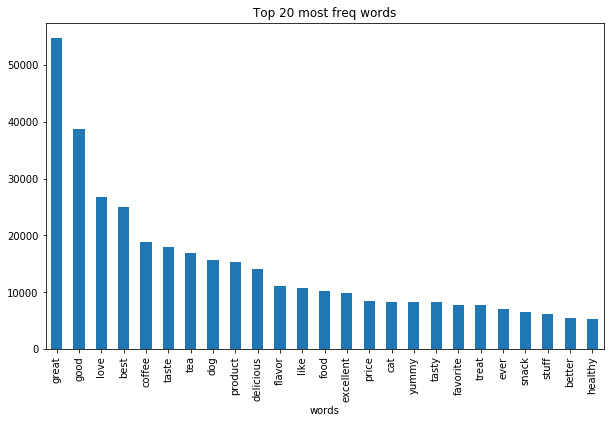

In [126]:
word_features = nltk.FreqDist(t)
print (" Word Features Length: ", len(word_features))
word_his = pd.DataFrame(word_features.most_common(25),columns=['words','count'])
word_his.plot(kind='bar',x=word_his['words'],legend=False,title='Top 20 most freq words',figsize=(10,6))

## Training The Classifiers

### Using PCA

After applying vectorization and before applying any kind of feature reduction/selection the size of the input matrix is 426340 x 27048. After applying PCA to reduce features, the input matrix size reduces to 426340 x 200. The decision to choose 200 components is a consequence of running and testing the algorithms with different number of components. 
The models are trained on the input matrix generated above. Test data is also transformed in a similar fashion to get a test matrix. Following are the results:


In [127]:
vec_all = CountVectorizer()
ctr_features_all = vec_all.fit_transform(Data_train)
print(ctr_features_all.shape)

(426340, 33760)


In [128]:
tf_vec_all = TfidfTransformer()
tr_features_all = tf_vec_all.fit_transform(ctr_features_all)

In [129]:
cte_features_all = vec_all.transform(Data_test)
te_features_all = tf_vec_all.transform(cte_features_all)

In [130]:
svd = TruncatedSVD(n_components=200)
tr_features_truncated = svd.fit_transform(tr_features_all)
print(tr_features_truncated.shape)

(426340, 200)


In [131]:
te_features_truncated = svd.transform(te_features_all)

In [132]:
svd = TruncatedSVD(n_components=200)
ctr_features_truncated = svd.fit_transform(ctr_features_all)
cte_features_truncated = svd.transform(cte_features_all)

##### Defining the classifier models

We have used the available classifiers from scikitlearn library.

In [133]:
models = {'BernoulliNB':BernoulliNB(binarize=0.5)
          ,'Decision Tree' : DecisionTreeClassifier(random_state=20160121, criterion='entropy'),
          'Perceptron': linear_model.Perceptron(n_iter=1000)}

In [134]:
results_svd = pd.DataFrame()

foldnum = 0
tfprediction = {}
cprediction = {}
for name,model in models.items():
        model.fit(ctr_features_truncated, Train_labels)
        tfprediction[name] = model.predict(cte_features_truncated)
        tfaccuracy = metrics.accuracy_score(tfprediction[name],Test_labels)
        
        results_svd.loc[foldnum,'Model']=name
        results_svd.loc[foldnum,'TF-IDF Accuracy ']=tfaccuracy
        foldnum = foldnum+1
print (results_svd)

C:\Users\ayush\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:117: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)


           Model  TF-IDF Accuracy 
0    BernoulliNB          0.801589
1  Decision Tree          0.810610
2     Perceptron          0.800245


In [135]:
for name,model in models.items():
    print ("Classification report for ",name)
    print(metrics.classification_report(Test_labels, tfprediction[name]))
    print("\n")

Classification report for  BernoulliNB
             precision    recall  f1-score   support

        neg       0.66      0.20      0.31     31169
        pos       0.81      0.97      0.88    110945

avg / total       0.78      0.80      0.76    142114



Classification report for  Decision Tree
             precision    recall  f1-score   support

        neg       0.56      0.60      0.58     31169
        pos       0.89      0.87      0.88    110945

avg / total       0.82      0.81      0.81    142114



Classification report for  Perceptron
             precision    recall  f1-score   support

        neg       0.64      0.20      0.30     31169
        pos       0.81      0.97      0.88    110945

avg / total       0.77      0.80      0.76    142114





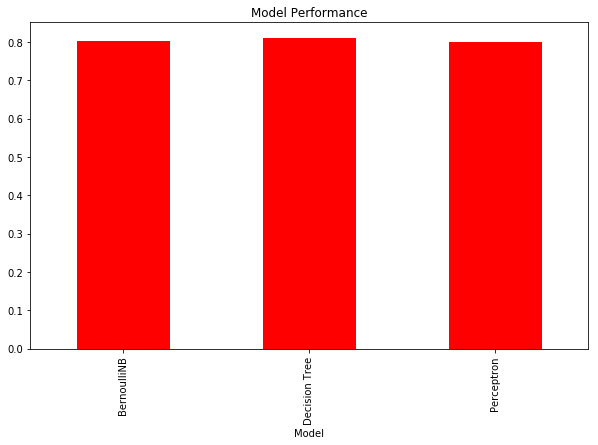

In [136]:
results_svd.plot(kind='bar',color=['r','g','b'],title='Model Performance',figsize=(10,6),x='Model',legend=False)

In [137]:
## comparing negative samples accuracies
negcom = pd.DataFrame()
for name,model in models.items():
    p= recall_score(Test_labels,tfprediction[name],pos_label='neg')
    negcom.loc[name,'recall'] = p

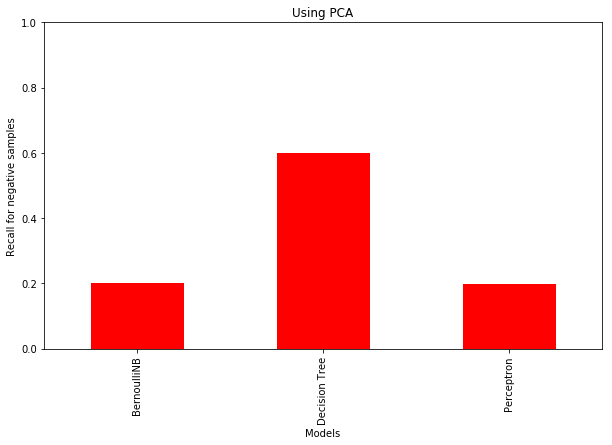

In [138]:
pl = negcom.plot(kind='bar',color=['r','g','y'],title='Using PCA',figsize=(10,6),legend=False)
pl.set(xlabel='Models',ylabel='Recall for negative samples')
lim = plt.ylim([0,1])

#### Results -
From the results, it can be seen that Decision Tree Classifier works best for the Dataset. This
implies that the dataset splits pretty well on words, which is kind of obvious as meaning of words
affects the sentiment of the review. Note that although the accuracy of Perceptron and
BernoulliNB does not look that bad but if one considers that the dataset is skewed and contains
78% positive reviews, predicting the majority class will always give at least 78% accuracy. So
compared to that perceptron and BernoulliNB doesn’t work that well in this case.


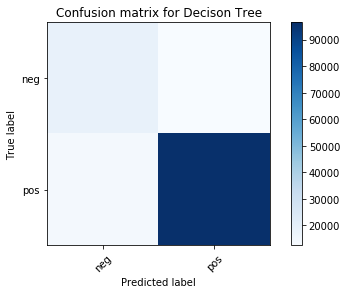

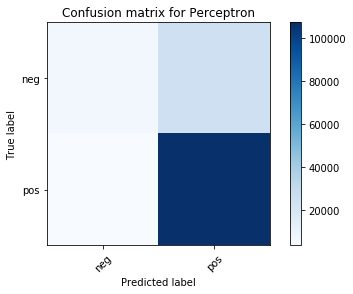

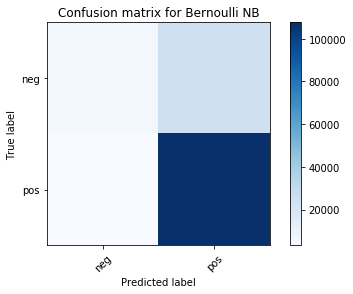

In [139]:
# Compute confusion matrix

cm = metrics.confusion_matrix(Test_labels,tfprediction['Decision Tree'])
np.set_printoptions(precision=2)
plt.figure()
plot_confusion_matrix(cm, title = "Confusion matrix for Decison Tree")    

cm = metrics.confusion_matrix(Test_labels,tfprediction['Perceptron'])
np.set_printoptions(precision=2)
plt.figure()
plot_confusion_matrix(cm, title = "Confusion matrix for Perceptron")    
cm = metrics.confusion_matrix(Test_labels,tfprediction['BernoulliNB'])
np.set_printoptions(precision=2)
plt.figure()
plot_confusion_matrix(cm, title = "Confusion matrix for Bernoulli NB")   



plt.show()

### Using 5000 most frequent features

The most important 5000 words are vectorized using Tf-idf transformer. Using the same transformer, the train and the test data are also vectorized. This essentially means that only those words of the training and testing data, which are among the most frequent 5000 words, will have numerical value in the generated matrices. These matrices are then used for training and evaluating the models. 


In [140]:
topwords = [fpair[0] for fpair in list(word_features.most_common(5000))]

In [141]:
print (word_features.max)

<bound method FreqDist.max of FreqDist({'great': 54703, 'good': 38734, 'love': 26815, 'best': 24969, 'coffee': 18858, 'taste': 17928, 'tea': 16851, 'dog': 15687, 'product': 15254, 'delicious': 14095, ...})>


In [142]:
print(word_features.freq)

<bound method FreqDist.freq of FreqDist({'great': 54703, 'good': 38734, 'love': 26815, 'best': 24969, 'coffee': 18858, 'taste': 17928, 'tea': 16851, 'dog': 15687, 'product': 15254, 'delicious': 14095, ...})>


In [143]:
print (word_features.most_common(25))

[('great', 54703), ('good', 38734), ('love', 26815), ('best', 24969), ('coffee', 18858), ('taste', 17928), ('tea', 16851), ('dog', 15687), ('product', 15254), ('delicious', 14095), ('flavor', 11169), ('like', 10832), ('food', 10256), ('excellent', 9894), ('price', 8425), ('cat', 8372), ('yummy', 8204), ('tasty', 8198), ('favorite', 7736), ('treat', 7733), ('ever', 7081), ('snack', 6489), ('stuff', 6183), ('better', 5473), ('healthy', 5211)]


In [144]:
vec = CountVectorizer()
c_fit = vec.fit_transform([' '.join(topwords)])

In [145]:
tf_vec = TfidfTransformer()
tf_fit = tf_vec.fit_transform(c_fit)

In [146]:
ctr_features = vec.transform(Data_train)
tr_features = tf_vec.transform(ctr_features)

In [147]:
cte_features = vec.transform(Data_test)
te_features = tf_vec.transform(cte_features)

In [148]:
models = {'BernoulliNB':BernoulliNB()
          ,'Decision Tree' : DecisionTreeClassifier(random_state=20160121, criterion='entropy'),
          'Perceptron': linear_model.Perceptron(n_iter=1000)}

In [149]:
results = pd.DataFrame()

foldnum = 0
tfprediction = {}
cprediction = {}
for name,model in models.items():
        
        model.fit(tr_features, Train_labels)
        tfprediction[name] = model.predict(te_features)
        tfaccuracy = metrics.accuracy_score(tfprediction[name],Test_labels)
        
        
        results.loc[foldnum,'TF-IDF Accuracy']=tfaccuracy
        results.loc[foldnum,'Model']=name
        foldnum = foldnum+1
print (results)

C:\Users\ayush\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:117: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)


   TF-IDF Accuracy          Model
0         0.855869    BernoulliNB
1         0.889933  Decision Tree
2         0.835386     Perceptron


In [150]:
for name,model in models.items():
    print ("Classification report for ",name)
    print(metrics.classification_report(Test_labels, tfprediction[name]))
    print("\n")

Classification report for  BernoulliNB
             precision    recall  f1-score   support

        neg       0.73      0.55      0.62     31169
        pos       0.88      0.94      0.91    110945

avg / total       0.85      0.86      0.85    142114



Classification report for  Decision Tree
             precision    recall  f1-score   support

        neg       0.78      0.69      0.73     31169
        pos       0.92      0.95      0.93    110945

avg / total       0.89      0.89      0.89    142114



Classification report for  Perceptron
             precision    recall  f1-score   support

        neg       0.67      0.50      0.57     31169
        pos       0.87      0.93      0.90    110945

avg / total       0.82      0.84      0.83    142114





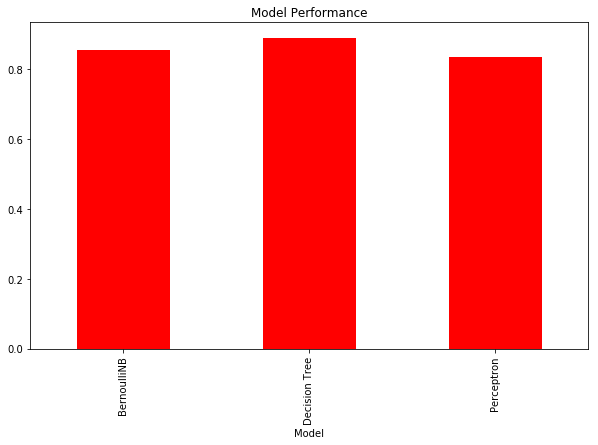

In [151]:
results.plot(kind='bar',color=['r','g','b','y'],title='Model Performance',figsize=(10,6),x='Model',legend=False)

In [152]:
## comparing negative samples accuracies
negcom = pd.DataFrame()
for name,model in models.items():
    p= recall_score(Test_labels,tfprediction[name],pos_label='neg')
    negcom.loc[name,'recall'] = p

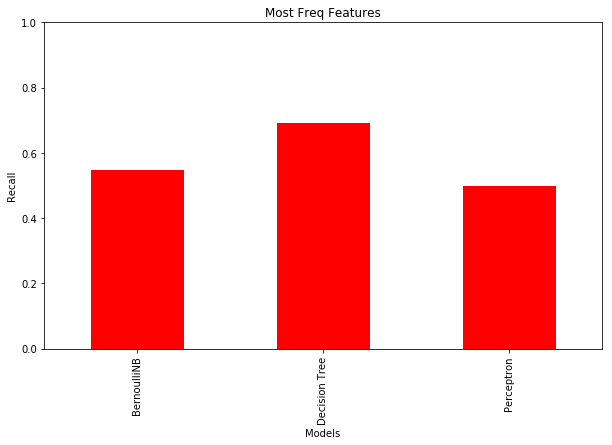

In [153]:
pl = negcom.plot(kind='bar',color=['r','g','b','y'],title='Most Freq Features',figsize=(10,6),legend=False)
pl.set(xlabel='Models',ylabel='Recall')
lim = plt.ylim([0,1])

##### Results - 
One important thing to note about Perceptron is that it only converges when data is linearly
separable. Since the number of features are so large one cannot tell if Perceptron will converge
on this dataset. Thus restricting the maximum iterations for it is important. Following is a
comparison of recall for negative samples.


### Without Feature Reduction/Selection

Lastly the models are trained without doing any feature reduction/selection step. Decision Tree Classifier runs pretty inefficiently for datasets having large number of features, so training the Decision Tree Classifier is avoided. Since the entire feature set is being used, the sequence of words (relative order) can be utilized to do a better prediction. For example : some words when used together have a different meaning compared to their meaning when considered alone like “not good” or “not bad”.  
The models are trained for 3 strategies called Unigram, Bigram and Trigram - 


#### For Unigram

In [154]:
vec_all = CountVectorizer()
ctr_features_all = vec_all.fit_transform(Data_train)

In [155]:
tf_vec_all = TfidfTransformer()
tr_features_all = tf_vec_all.fit_transform(ctr_features_all)

In [156]:
cte_features_all = vec_all.transform(Data_test)
te_features_all = tf_vec_all.transform(cte_features_all)

In [157]:
models = {'BernoulliNB':BernoulliNB()
          ,'Decision Tree' : DecisionTreeClassifier(random_state=20160121, criterion='entropy'),'Perceptron': linear_model.Perceptron(n_iter=1000)}

In [159]:

results_all_uni = pd.DataFrame()


foldnum = 0
tfprediction = {}
cprediction = {}
for name,model in models.items():
        
        model.fit(tr_features_all, Train_labels)
        tfprediction[name] = model.predict(te_features_all)
        tfaccuracy = metrics.accuracy_score(tfprediction[name],Test_labels)
       
        results_all_uni.loc[foldnum,'TF-IDF Accuracy']=tfaccuracy
        results_all_uni.loc[foldnum,'Model']=name
        foldnum = foldnum+1
print (results_all_uni)

C:\Users\ayush\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:117: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)


   TF-IDF Accuracy          Model
0         0.862371    BernoulliNB
1         0.891045  Decision Tree
2         0.837834     Perceptron


In [160]:
for name,model in models.items():
    print ("Classification report for ",name)
    print(metrics.classification_report(Test_labels, tfprediction[name]))

Classification report for  BernoulliNB
             precision    recall  f1-score   support

        neg       0.75      0.55      0.64     31169
        pos       0.88      0.95      0.91    110945

avg / total       0.85      0.86      0.85    142114

Classification report for  Decision Tree
             precision    recall  f1-score   support

        neg       0.77      0.71      0.74     31169
        pos       0.92      0.94      0.93    110945

avg / total       0.89      0.89      0.89    142114

Classification report for  Perceptron
             precision    recall  f1-score   support

        neg       0.65      0.57      0.61     31169
        pos       0.88      0.91      0.90    110945

avg / total       0.83      0.84      0.83    142114



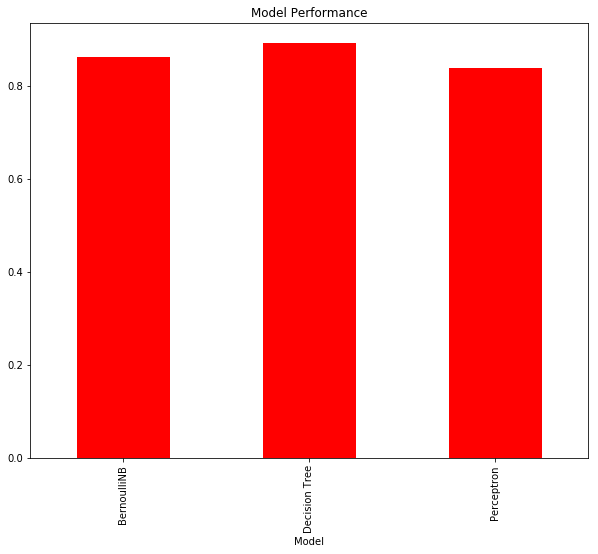

In [161]:
results_all_uni.plot(kind='bar',color=['r','g','b'],title='Model Performance',figsize=(10,8),x='Model',legend=False)

In [162]:
## comparing negative samples accuracies
negcom = pd.DataFrame()
for name,model in models.items():
    p= recall_score(Test_labels,tfprediction[name],pos_label='neg')
    negcom.loc[name,'recall'] = p

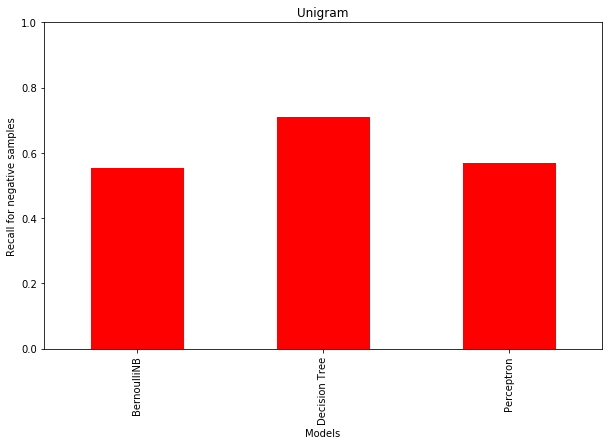

In [163]:
pl = negcom.plot(kind='bar',color=['R','G','B'],title='Unigram',figsize=(10,6),legend=False)
pl.set(xlabel='Models',ylabel='Recall for negative samples')
lim = plt.ylim([0,1])

#### Using bigram

In [164]:
## using countvectorizer to generate count vectors for the training data.
vec_all = CountVectorizer(ngram_range=(1,2))
ctr_features_all = vec_all.fit_transform(Data_train)

In [165]:
tf_vec_all = TfidfTransformer()
tr_features_all = tf_vec_all.fit_transform(ctr_features_all)

In [166]:
cte_features_all = vec_all.transform(Data_test)
te_features_all = tf_vec_all.transform(cte_features_all)

In [167]:
print ((ctr_features_all.shape))

(426340, 265029)


In [168]:

results_all_bi = pd.DataFrame()

tfprediction = {}
cprediction = {}
foldnum = 0
for name,model in models.items():
        
        model.fit(tr_features_all, Train_labels)
        tfprediction[name] = model.predict(te_features_all)
        tfaccuracy = metrics.accuracy_score(tfprediction[name],Test_labels)
         
        results_all_bi.loc[foldnum,'TF-IDF Accuracy']=tfaccuracy
        results_all_bi.loc[foldnum,'Model']=name
        foldnum = foldnum+1
print (results_all_bi)

C:\Users\ayush\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:117: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)


   TF-IDF Accuracy          Model
0         0.872377    BernoulliNB
1         0.891017  Decision Tree
2         0.873369     Perceptron


In [169]:
for name,model in models.items():
    print ("Classification report for ",name)
    print(metrics.classification_report(Test_labels, tfprediction[name]))
    print("\n")

Classification report for  BernoulliNB
             precision    recall  f1-score   support

        neg       0.83      0.52      0.64     31169
        pos       0.88      0.97      0.92    110945

avg / total       0.87      0.87      0.86    142114



Classification report for  Decision Tree
             precision    recall  f1-score   support

        neg       0.77      0.72      0.74     31169
        pos       0.92      0.94      0.93    110945

avg / total       0.89      0.89      0.89    142114



Classification report for  Perceptron
             precision    recall  f1-score   support

        neg       0.70      0.73      0.72     31169
        pos       0.92      0.91      0.92    110945

avg / total       0.87      0.87      0.87    142114





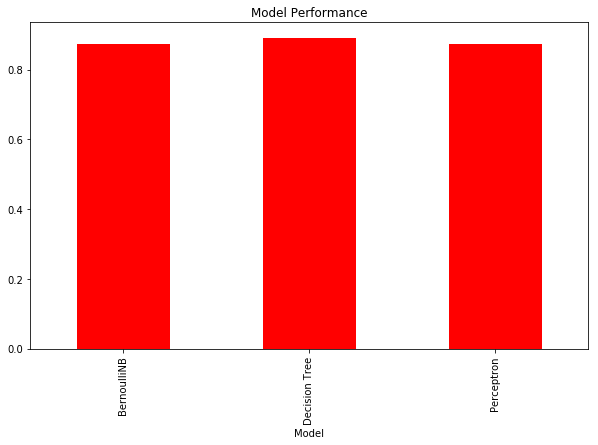

In [170]:
results_all_bi.plot(kind='bar',color=['r','g','b'],title='Model Performance',figsize=(10,6),x='Model',legend=False)

In [171]:
## comparing negative samples accuracies
negcom = pd.DataFrame()
for name,model in models.items():
    p= recall_score(Test_labels,tfprediction[name],pos_label='neg')
    negcom.loc[name,'recall'] = p

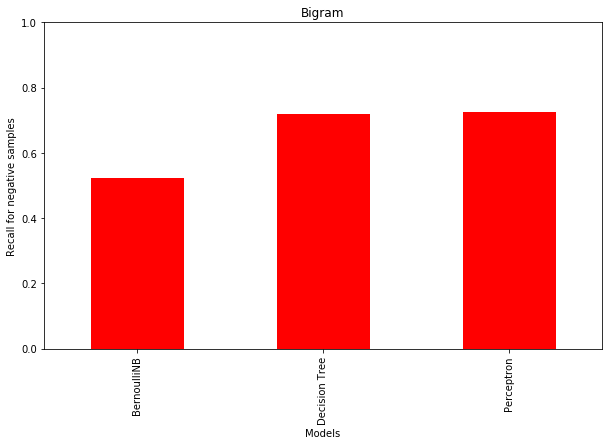

In [172]:
pl = negcom.plot(kind='bar',color=['r','g','b','y'],title='Bigram',figsize=(10,6),legend=False)
pl.set(xlabel='Models',ylabel='Recall for negative samples')
lim = plt.ylim([0,1])

In [173]:
vec_all = CountVectorizer(ngram_range=(1,3))
ctr_features_all = vec_all.fit_transform(Data_train)

In [174]:
print(ctr_features_all.shape)

(426340, 516377)


In [175]:
tf_vec_all = TfidfTransformer()
tr_features_all = tf_vec_all.fit_transform(ctr_features_all)

In [176]:

cte_features_all = vec_all.transform(Data_test)
te_features_all = tf_vec_all.transform(cte_features_all)

In [177]:
results_all_tri = pd.DataFrame()
tfprediction = {}
cprediction = {}
foldnum = 0
for name,model in models.items():
        
        model.fit(tr_features_all, Train_labels)
        tfprediction[name] = model.predict(te_features_all)
        tfaccuracy = metrics.accuracy_score(tfprediction[name],Test_labels)
       
        results_all_tri.loc[foldnum,'TF-IDF Accuracy']=tfaccuracy
        results_all_tri.loc[foldnum,'Model']=name
        foldnum = foldnum+1
print (results_all_tri)

C:\Users\ayush\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:117: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)


   TF-IDF Accuracy          Model
0         0.850592    BernoulliNB
1         0.891059  Decision Tree
2         0.880082     Perceptron


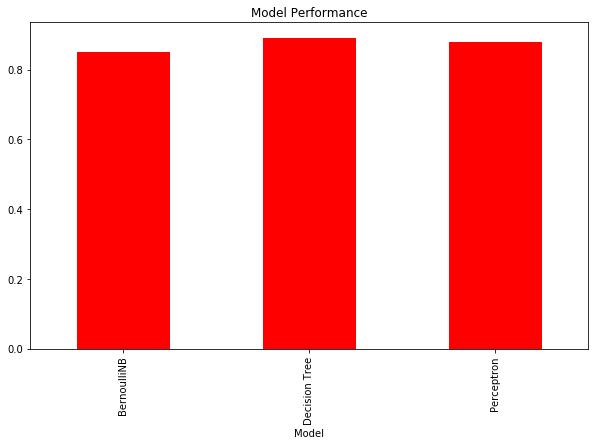

In [178]:
results_all_tri.plot(kind='bar',color=['r','g','b'],title='Model Performance',figsize=(10,6),x='Model',legend=False)

In [179]:
for name,model in models.items():
    print ("Classification report for ",name)
    print(metrics.classification_report(Test_labels, tfprediction[name]))
    print("\n")

Classification report for  BernoulliNB
             precision    recall  f1-score   support

        neg       0.88      0.37      0.52     31169
        pos       0.85      0.99      0.91    110945

avg / total       0.85      0.85      0.83    142114



Classification report for  Decision Tree
             precision    recall  f1-score   support

        neg       0.77      0.72      0.74     31169
        pos       0.92      0.94      0.93    110945

avg / total       0.89      0.89      0.89    142114



Classification report for  Perceptron
             precision    recall  f1-score   support

        neg       0.73      0.73      0.73     31169
        pos       0.92      0.92      0.92    110945

avg / total       0.88      0.88      0.88    142114





In [180]:
## comparing negative samples accuracies
negcom = pd.DataFrame()
for name,model in models.items():
    p= recall_score(Test_labels,tfprediction[name],pos_label='neg')
    negcom.loc[name,'recall'] = p

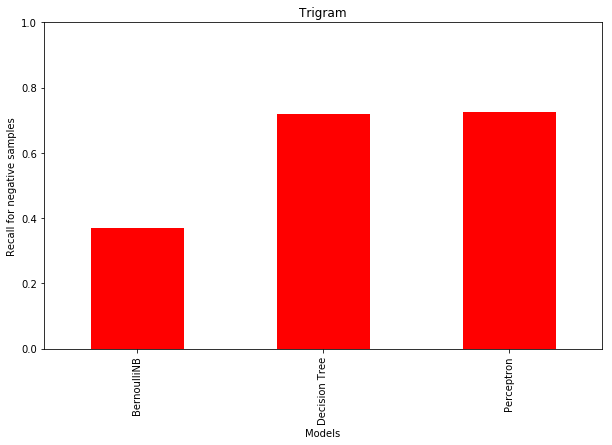

In [181]:
pl = negcom.plot(kind='bar',color=['r','g','b','y'],title='Trigram',figsize=(10,6),legend=False)
pl.set(xlabel='Models',ylabel='Recall for negative samples')
lim = plt.ylim([0,1])

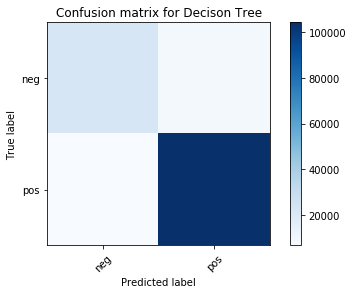

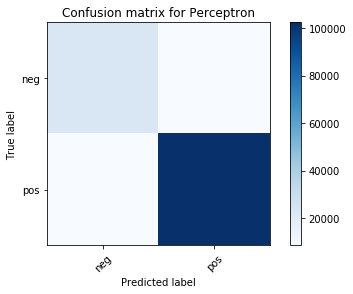

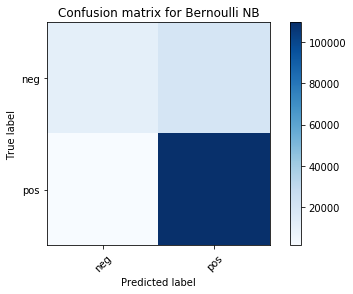

In [182]:

# Compute confusion matrix
# Compute confusion matrix

cm = metrics.confusion_matrix(Test_labels,tfprediction['Decision Tree'])
np.set_printoptions(precision=2)
plt.figure()
plot_confusion_matrix(cm, title = "Confusion matrix for Decison Tree")    

cm = metrics.confusion_matrix(Test_labels,tfprediction['Perceptron'])
np.set_printoptions(precision=2)
plt.figure()
plot_confusion_matrix(cm, title = "Confusion matrix for Perceptron")    
cm = metrics.confusion_matrix(Test_labels,tfprediction['BernoulliNB'])
np.set_printoptions(precision=2)
plt.figure()
plot_confusion_matrix(cm, title = "Confusion matrix for Bernoulli NB")   

plt.show()
plt.show()

##### Results - 
Decision Tree gives accuracy as high as 89.1 % and even perceptron accuracy is very high. The
recall/precision values for negative samples are higher than ever. Thus, increasing the n gram
feature level can lead us to better classification.
Since Decision tree performs best in all three cases, let’s do a little more analysis of it with the
help of a confusion matrix. A confusion matrix plots the True labels against predicted labels. It is
just a good way to visualize the classification report.


### Using Sentence as a feature
Like ‘I love the good quality food here.” will be converted to “love good quality food”. Instead of tokenizing it further into words we took whole sentence as a feature. Thus for the whole dataset we collected sentences features and tried to classify on the basis of these features. So after preprocessing we have 182626 features. By using these features we try to predict on the test data. 

In [183]:
t = []
for line in Data_train:
    l = preprocessing(line)
    if(len(l)!=0):
        t.append(l)

In [184]:
y = []
for line in Data_test:
    l = preprocessing(line)
    if(len(l)!=0):
        y.append(l)

In [185]:
te_feat = nltk.FreqDist(y)

 Sentence Features Length:  182626


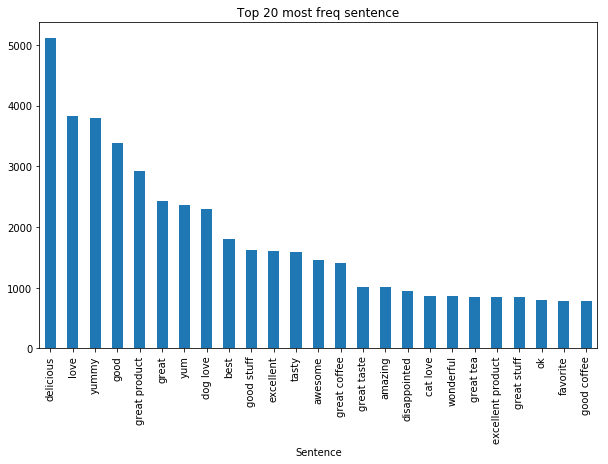

In [186]:
sent_features = nltk.FreqDist(t)
print (" Sentence Features Length: ", len(sent_features))
word_his = pd.DataFrame(sent_features.most_common(25),columns=['Sentence','count'])
word_his.plot(kind='bar',x=word_his['Sentence'],legend=False,title='Top 20 most freq sentence',figsize=(10,6))

In [187]:
print(sent_features.elements)

<bound method Counter.elements of FreqDist({'delicious': 5116, 'love': 3820, 'yummy': 3788, 'good': 3384, 'great product': 2924, 'great': 2430, 'yum': 2354, 'dog love': 2303, 'best': 1802, 'good stuff': 1628, ...})>


In [188]:
te_sentence = [fpair[0] for fpair in list(te_feat.most_common(Test_labels.shape[0]))]
te_sentence

['delicious',
 'love',
 'yummy',
 'good',
 'great product',
 'great',
 'yum',
 'dog love',
 'tasty',
 'best',
 'excellent',
 'good stuff',
 'great coffee',
 'awesome',
 'amazing',
 'great taste',
 'disappointed',
 'great stuff',
 'cat love',
 'great tea',
 'good product',
 'ok',
 'excellent product',
 'wonderful',
 'good coffee',
 'favorite',
 'love stuff',
 'fantastic',
 'taste great',
 'great flavor',
 'great snack',
 'bad',
 'pretty good',
 'wow',
 'work',
 'perfect',
 'yuck',
 'like',
 'love tea',
 'great treat',
 'okay',
 'expected',
 'disappointing',
 'sweet',
 'yumm',
 'coffee',
 'buy',
 'good tea',
 'pleased',
 'excellent coffee',
 'addictive',
 'love product',
 'great deal',
 'best ever',
 'taste good',
 'great value',
 'love coffee',
 'loved',
 'best coffee ever',
 'kid love',
 'simply best',
 'great price',
 'horrible',
 'really good',
 'awful',
 'nice',
 'fabulous',
 'meh',
 'disgusting',
 'great dog food',
 'impressed',
 'delish',
 'good great',
 'happy',
 'expensive',
 'm

In [189]:
sentence = [fpair[0] for fpair in list(sent_features.most_common(Train_labels.shape[0]))]
sentence

['delicious',
 'love',
 'yummy',
 'good',
 'great product',
 'great',
 'yum',
 'dog love',
 'best',
 'good stuff',
 'excellent',
 'tasty',
 'awesome',
 'great coffee',
 'great taste',
 'amazing',
 'disappointed',
 'cat love',
 'wonderful',
 'great tea',
 'excellent product',
 'great stuff',
 'ok',
 'favorite',
 'good coffee',
 'good product',
 'fantastic',
 'love stuff',
 'taste great',
 'great snack',
 'pretty good',
 'great flavor',
 'work',
 'perfect',
 'bad',
 'yuck',
 'wow',
 'like',
 'love tea',
 'expected',
 'okay',
 'yumm',
 'great treat',
 'disappointing',
 'buy',
 'sweet',
 'great value',
 'coffee',
 'best ever',
 'addictive',
 'great deal',
 'delish',
 'good tea',
 'love coffee',
 'really good',
 'pleased',
 'kid love',
 'love product',
 'nice',
 'good great',
 'excellent coffee',
 'awful',
 'absolutely delicious',
 'great food',
 'taste good',
 'best coffee ever',
 'great price',
 'fabulous',
 'great buy',
 'loved',
 'happy',
 'soo good',
 'terrible',
 'favorite tea',
 'sim

In [190]:
vec_all = CountVectorizer()
ctr_features_all = vec_all.fit_transform(sentence)

In [191]:
print(ctr_features_all.shape)

(182626, 33730)


In [192]:
tf_vec_all = TfidfTransformer()
tr_features_all = tf_vec_all.fit_transform(ctr_features_all)

In [193]:
cte_features_all = vec_all.transform(te_sentence)
te_features_all = tf_vec_all.transform(cte_features_all)
print(te_features_all.shape)

(76895, 33730)


In [194]:
results_all_line = pd.DataFrame()
tfprediction = {}
cprediction = {}
foldnum = 0
for name,model in models.items():
        
        model.fit(tr_features_all, Train_labels[0:ctr_features_all.shape[0]])
        tfprediction[name] = model.predict(te_features_all)
        tfaccuracy = metrics.accuracy_score(tfprediction[name],Test_labels[0:te_features_all.shape[0]])
       
        results_all_line.loc[foldnum,'TF-IDF Accuracy']=tfaccuracy
        results_all_line.loc[foldnum,'Model']=name
        foldnum = foldnum+1
print (results_all_line)

C:\Users\ayush\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:117: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)


   TF-IDF Accuracy          Model
0         0.769504    BernoulliNB
1         0.670421  Decision Tree
2         0.684271     Perceptron


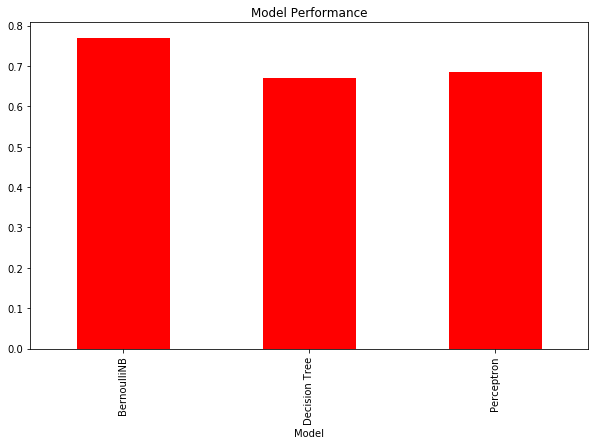

In [195]:
results_all_line.plot(kind='bar',color=['r','g','b'],title='Model Performance',figsize=(10,6),x='Model',legend=False)

In [196]:
for name,model in models.items():
    print ("Classification report for ",name)
    print(metrics.classification_report(Test_labels[0:76895], tfprediction[name]))
    print("\n")

Classification report for  BernoulliNB
             precision    recall  f1-score   support

        neg       0.20      0.02      0.03     16924
        pos       0.78      0.98      0.87     59971

avg / total       0.65      0.77      0.68     76895



Classification report for  Decision Tree
             precision    recall  f1-score   support

        neg       0.22      0.19      0.20     16924
        pos       0.78      0.81      0.79     59971

avg / total       0.66      0.67      0.66     76895



Classification report for  Perceptron
             precision    recall  f1-score   support

        neg       0.21      0.16      0.18     16924
        pos       0.78      0.83      0.80     59971

avg / total       0.65      0.68      0.67     76895





In [197]:
## comparing negative samples accuracies
negcom = pd.DataFrame()
for name,model in models.items():
    p= recall_score(Test_labels[0:te_features_all.shape[0]],tfprediction[name],pos_label='neg')
    negcom.loc[name,'recall'] = p

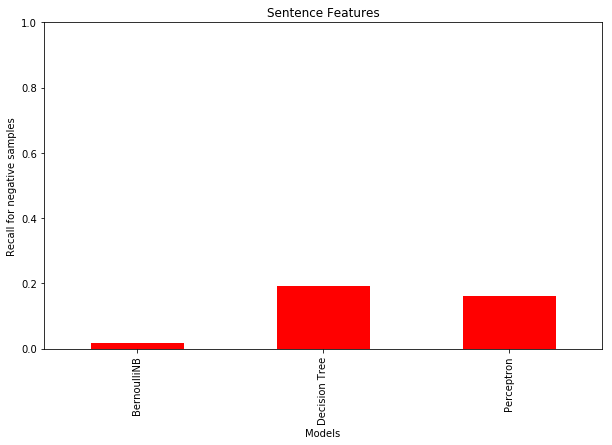

In [198]:
pl = negcom.plot(kind='bar',color=['r','g','b'],title='Sentence Features',figsize=(10,6),legend=False)
pl.set(xlabel='Models',ylabel='Recall for negative samples')
lim = plt.ylim([0,1])

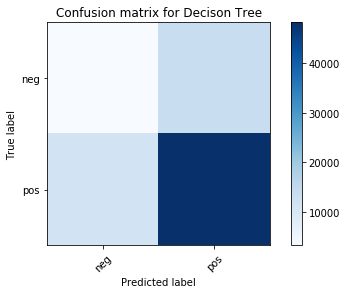

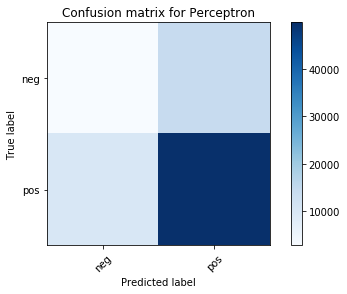

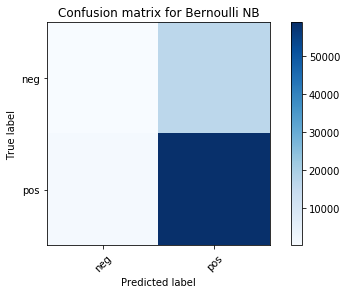

In [200]:
# Compute confusion matrix

cm = metrics.confusion_matrix(Test_labels[0:te_features_all.shape[0]],tfprediction['Decision Tree'])
np.set_printoptions(precision=2)
plt.figure()
plot_confusion_matrix(cm, title = "Confusion matrix for Decison Tree")    

cm = metrics.confusion_matrix(Test_labels[0:te_features_all.shape[0]],tfprediction['Perceptron'])
np.set_printoptions(precision=2)
plt.figure()
plot_confusion_matrix(cm, title = "Confusion matrix for Perceptron")    
cm = metrics.confusion_matrix(Test_labels[0:te_features_all.shape[0]],tfprediction['BernoulliNB'])
np.set_printoptions(precision=2)
plt.figure()
plot_confusion_matrix(cm, title = "Confusion matrix for Bernoulli NB")   

plt.show()
plt.show()